In [1]:
%matplotlib widget
%matplotlib inline
import sys
from sys import platform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import ScalarFormatter
import numpy as np
import pickle
import seaborn as sns
import scipy
import emcee
import corner
from IPython.display import display, Math
from tqdm import tqdm
from multiprocessing import Pool

from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import functional_models, fitting

import stingray.events as ev
import stingray.lightcurve as lc
from stingray import io
import stingray.powerspectrum as powspec 
import stingray.crossspectrum as crossspec
from hendrics.efsearch import dyn_folding_search, z_n_search, folding_search
import stingray.gti as sting_gti
import stingray.pulse.pulsar as plsr
from stingray import stats


sns.set_context('talk')
# sns.set_style("whitegrid")
sns.set_palette("colorblind")

sys.path.insert(1, '/Users/sean/scripts/helpers')

from stingray_plus import *

def minimize_remainder(arr, min_div, max_div):
    divisors = np.linspace(min_div, max_div, num=100)
    remainders = []
    for div in divisors:
        remainders.append(np.sum(np.mod(arr, div)))
        
    return divisors[np.argmin(remainders)]

def power_law(f, B, gamma):
    return B*np.power(f,gamma)

def Lorentzian(f, peakf, Q, A):
    # gamma = HWHM
    # peakf = centroid frequency
    gamma = peakf/(2.0 * Q)
    return (A * np.square(gamma)/(np.pi*gamma*(np.square(f-peakf) + np.square(gamma))))

def Lorentzian_C(f, peakf, Q, A, C):
    return Lorentzian(f, peakf, Q, A) + C

def Lorentzian_power(f, peakf, Q, A, B, gamma):
    return Lorentzian(f, peakf, Q, A) + power_law(f, B, gamma)

def N_Lorentzian(f, *args):
    N = int(len(args)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    model = np.zeros(np.shape(f))
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def N_Lorentzian_C(f, *args):
    N = int((len(args)-1)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    C = args[-1]
    model = C * np.ones(np.shape(f))
    for i in range(N):
        model = model + Lorentzian(f, peak_nu[i], Qs[i], As[i])
        
    return model

def N_Lorentzian_power(f, *args):
    N = int((len(args)-2)/3)
    peak_nu = args[:N]
    Qs = args[N:N+N]
    As = args[N+N:N+N+N]
    B, alpha = args[-2:]
    model = power_law(f, B, alpha)
    for i in range(N):
        gamma = peak_nu[i]/(2.0 * Qs[i])
        model = model + (As[i] * np.square(gamma)/(np.pi*gamma*(np.square(f-peak_nu[i]) + np.square(gamma))))
        
    return model

def QPO_scan(cross_spec, f_min=1e-4, f_max=2000., f_bin=1000, n_lorentz = 1):
    f_mask = (cross_spec.freq > f_min) * (cross_spec.freq < f_max)
    freq_steps = np.logspace(np.log10(cross_spec.freq[f_mask][0]), np.log10(cross_spec.freq[f_mask][-1]), f_bin + 2)
    xdata = cross_spec.freq[f_mask]
    ydata = cross_spec.power[f_mask]
    sigma = cross_spec.power_err[f_mask]
    
    pl_popt, pl_pcov = scipy.optimize.curve_fit(power_law, xdata, ydata, sigma = sigma, p0 = [10., -1.0], \
                                                bounds=np.array([(0.0, np.inf), (-np.inf, 0.0)]).T)
    print(pl_popt)
    chisq0 = np.sum(((ydata - power_law(xdata, *pl_popt)) / sigma) ** 2)
    chisq = []
    for i in tqdm(range(len(freq_steps[1:-1]))):
        f = freq_steps[i+1]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = [f, 2.0, 0.1, pl_popt[0], pl_popt[1]], \
                                              bounds=np.array([(f - (f-freq_steps[i])/2., f + (freq_steps[i+2] - f)/2.0), (1.0,np.inf), (0.0,np.inf), (0.0, np.inf), (-np.inf, 0.0)]).T)
        chisq.append(np.sum(((ydata - Lorentzian_power(xdata, *popt)) / sigma) ** 2))
    dof = len(xdata)-len(popt)
    return freq_steps[1:-1], chisq0, np.array(chisq), dof



def fit_peaks(xdata, ydata, sigma, nu_peak):
    
    popt_arr = []
    pcov_arr = []

    for i, p in enumerate(nu_peak):
        f_bound = None
        if len(nu_peak)==1:
            f_bound = (np.min(xdata), np.max(xdata))
        else:
            if i == 0:
                f_bound = (np.min(xdata), p + (nu_peak[i+1] - p)/2)
            elif i==len(nu_peak)-1:
                f_bound = (p + (nu_peak[i-1] - p)/2, np.max(xdata))
            else:
                f_bound = (p + (nu_peak[i-1] - p)/2, p + (nu_peak[i+1] - p)/2)

        par_bounds = np.array([f_bound, (1.0,np.inf), (0, np.inf), (0, np.inf), (-np.inf, 0.0)]).T
        p0 = [p, 5.0, 0.1, 0.02, -0.5]
        popt, pcov = scipy.optimize.curve_fit(Lorentzian_power, xdata, ydata, sigma = sigma, p0 = p0, bounds = par_bounds)
        popt_arr.append(popt)
        pcov_arr.append(pcov)

    popt_arr = np.array(popt_arr)
    pcov_arr = np.array(pcov_arr)

    return popt_arr, pcov_arr

def get_rms(events, centroids, radius, PI_min=35, PI_max=1210, nu_min=1e-4, nu_max=100., split_time=512, bin_time = 1/1024, plot = False):
    
    curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroids[0], radius = radius)
    curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroids[1], radius = radius)
    
    average_CPDS = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')
    
    if plot:
        f_res = 0.1
        plt.figure(figsize=(9,6))
        averaged_cross_log = average_CPDS.rebin_log(f=f_res)
        averaged_cross_log_err = average_CPDS.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
        plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
        plt.xscale('log')
        plt.ylim((1e-4,5*np.max(averaged_cross_log.power.real)))
        plt.yscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Leahy Power')
        plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
        plt.tight_layout()
        plt.show()
#         plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's.pdf')
        plt.close()
    
    rms_square = np.sum(average_CPDS.power[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])*average_CPDS.df
    rms_square_err = np.sqrt(np.sum(np.square(average_CPDS.power_err[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])))*average_CPDS.df
    
    if rms_square < 0.0:
        uplim = True
        rms = np.sqrt(rms_square + 2.6*rms_square_err)
    else:
        uplim = False
        rms = np.sqrt(rms_square)
        
    rms_err = np.sqrt(np.sum(np.square(average_CPDS.power_err[(average_CPDS.freq > nu_min) * (average_CPDS.freq < nu_max)])))*average_CPDS.df/(2*rms)

    return rms, rms_err, uplim

def model_continuum_noise(cpds, plot=True, plot_dir='/Users/sean/Desktop/', f_res = 0.5, text=''):
    n_L = 0
    L_args = []
    L_bounds = []
    chisq0 = np.sum(((cpds.power-np.mean(cpds.power))/ cpds.power_err) ** 2)
    chisq = []
    popt_list = []
    pcov_list = []
    del_chisq = -100000
    while del_chisq < 0.0:
        n_L += 1
        if n_L ==1:
            L_args = np.array([1.0, 0.1, 10.])
            L_bounds = np.array([[[0.0, np.max(cpds.freq)], [0.0, 2.0], [0,np.inf]]])
        else:
            L_args = np.vstack((L_args, [1.0, 0.1, 10.]))
            L_bounds = np.concatenate((L_bounds, [[(0.0, np.max(cpds.freq)), (0.0, 10.0), (0,np.inf)]]))
        
#         temp_p0 = np.concatenate((L_args.T.flatten(), [0.0]))
#         temp_bounds = [np.concatenate((L_bounds.T.flatten()[:3*n_L], )), np.concatenate((L_bounds.T.flatten()[3*n_L:], [np.inf]))]
        
        temp_p0 = L_args.T.flatten()
        temp_bounds = [L_bounds.T.flatten()[:3*n_L], L_bounds.T.flatten()[3*n_L:]]
        
        popt, pcov = scipy.optimize.curve_fit(N_Lorentzian, cpds.freq, cpds.power, sigma = cpds.power_err, \
                                              p0 = temp_p0, bounds= temp_bounds)
        temp_chisq = np.sum(((cpds.power - N_Lorentzian(cpds.freq, *popt)) / cpds.power_err) ** 2)
        
        if n_L==1:
            del_chisq = temp_chisq-chisq0
        else:
            del_chisq = temp_chisq-chisq[-1]
        chisq.append(temp_chisq)
        popt_list.append(popt)
        pcov_list.append(pcov)
        
        L_args = np.array([popt[:n_L], popt[n_L:n_L + n_L], popt[n_L+n_L:n_L+n_L+n_L]]).T

        if plot:
            cpds_log = cpds.rebin_log(f=f_res)
            temp_err = cpds.df*np.power(1.+f_res, range(len(cpds_log.freq)))/2.

            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power*cpds_log.freq, xerr=temp_err, \
                         yerr=cpds_log.power_err*cpds_log.freq, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power*cpds_log.freq, [(cpds_log.power*cpds_log.freq)[-1]]]), where='post', color='black', lw=0.5)
            
            for i in range(n_L):
                plt.plot(cpds.freq, Lorentzian(cpds.freq, *((L_args[i])))*cpds.freq, color='red', ls='dotted', lw=1.0)
            plt.plot(cpds.freq,N_Lorentzian(cpds.freq, *popt)*cpds.freq, color='red', lw=1.0)
            plt.xscale('log')
            plt.ylim((1e-4,1))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
            plt.text(2e-3, 0.3, text, fontsize=20)
            plt.tight_layout()
            plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_' + str(int(n_L)) + '_comps.pdf')
            plt.close()
            
            plt.figure(figsize=(9,6))
            plt.errorbar(cpds_log.freq, cpds_log.power, xerr=temp_err, \
                         yerr=cpds_log.power_err, fmt='none', lw=0.5, color='black')
            plt.step(np.concatenate([cpds_log.freq-temp_err, [cpds_log.freq[-1]+temp_err[-1]]]), \
                     np.concatenate([cpds_log.power, [cpds_log.power[-1]]]), where='post', color='black', lw=0.5)

            for i in range(n_L):
                plt.plot(cpds.freq, Lorentzian(cpds.freq, *((L_args[i]))), color='red', ls='dotted', lw=1.0)
            plt.plot(cpds.freq,N_Lorentzian(cpds.freq, *popt), color='red', lw=1.0)
            plt.xscale('log')
            plt.ylim((1e-4,1))
            plt.yscale('log')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
            plt.text(2e-3, 0.3, text, fontsize=20)
            plt.tight_layout()
            plt.savefig(plot_dir + 'CPDS_Pnu_continuum_' + str(int(n_L)) + '_comps.pdf')
            plt.close()
    
    return n_L, popt_list, pcov_list, chisq0, chisq





## Epoch 1 (OBS 002)

In [2]:
OBSID = '90601315002'

if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/AT2019wey/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/AT2019wey/'

products_dir = root_dir + OBSID + '_products/'
timing_dir = root_dir + OBSID + '_timing_products/'
plot_dir = root_dir + 'figures/' + OBSID + '/'


Working on Macbook


In [3]:
plt.ion()
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [491.47526,554.84267]
centroid_B = [496.30398,552.47484]
extraction_radius = 24.409024 # 60 arcsec

plt.ion()

curve_A = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curve_B = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curve_A, curve_B)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

# plt.figure(figsize = (9,6))
# plt.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 0.5)
# plt.xlabel('Time (s)')
# plt.ylabel('NuSTAR count rate')
# plt.tight_layout()
# plt.show()
# plt.close()



In [4]:
bin_time = 1/512
split_time = 256

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
150it [00:09, 16.21it/s]
150it [00:08, 17.73it/s]
150it [00:08, 17.62it/s]


In [5]:
f_res = 0.5
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', color='black', lw=0.5)
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,1))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.text(2e-3, 0.3, 'Obs 002', fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, fmt='none', color='black', lw=0.5)
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,1))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.text(2e-3, 0.3, 'Obs 002', fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

# Model continuum

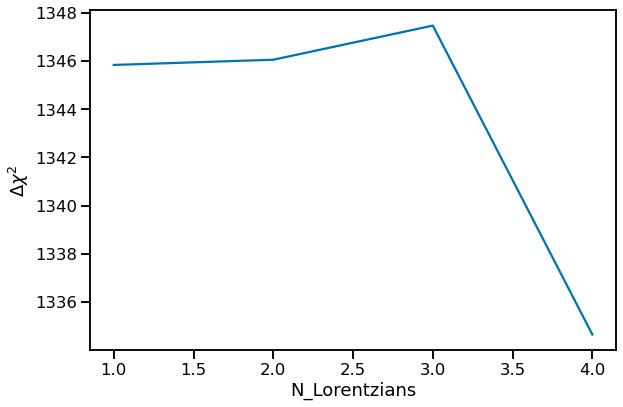

In [6]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir, f_res=f_res, text='Obs 002')

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L)) + 1, -del_chisq)
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\Delta\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()


In [7]:
best_popt_i = 0
# print(popt_list[best_popt_i])
# print(np.sqrt(np.diag(pcov_list[best_popt_i])))

nu_0 = popt_list[best_popt_i][0]
Q = popt_list[best_popt_i][1]
A = popt_list[best_popt_i][2]

nu_0_err = np.sqrt(np.diag(pcov_list[best_popt_i]))[0]
Q_err = np.sqrt(np.diag(pcov_list[best_popt_i]))[1]
A_err = np.sqrt(np.diag(pcov_list[best_popt_i]))[2]

nu_max = nu_0*np.sqrt(1+(1/(4*np.square(Q))))
nu_max_err = np.sqrt(np.square(nu_max*nu_0_err/nu_0) + np.square(np.square(nu_0)*Q_err/(4*nu_max*np.power(Q, 3))))

rms = np.sqrt(A)
rms_err = A_err/(2*np.sqrt(A))

print(nu_max)
print(nu_max_err)
print(Q)
print(Q_err)
print(rms)
print(rms_err)

0.048084795706075746
37.24445491291661
0.0002783886148534383
0.15244711076699086
0.5426991343385261
0.04863476511733314


# RMS-Energy relation

In [8]:
keV_list = np.array([[3.0, 5.0], [5.0, 8.0], [8.0, 15.0], [15.0, 50.0]])
PI_list = eV_to_PI(keV_list*1000)
rms_list = []
rms_err_list = []
uplim_list = []

for x in PI_list:
    print(x)
    rms, rms_err, uplim = get_rms(events, [centroid_A, centroid_B], extraction_radius, PI_min=x[0], PI_max=x[1], nu_min=1e-4, nu_max=1., split_time=split_time, bin_time = bin_time, plot = False)
    rms_list.append(rms*100)
    rms_err_list.append(rms_err*100)
    uplim_list.append(uplim)
    





[35. 85.]


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
150it [00:09, 15.41it/s]
150it [00:08, 18.32it/s]
150it [00:08, 18.31it/s]


[ 85. 160.]


150it [00:08, 17.20it/s]
150it [00:07, 19.59it/s]
150it [00:08, 17.35it/s]


[160. 335.]


150it [00:08, 16.81it/s]
150it [00:07, 20.64it/s]
150it [00:07, 19.48it/s]


[ 335. 1210.]


150it [00:08, 17.13it/s]
150it [00:07, 20.13it/s]
150it [00:07, 19.86it/s]


In [9]:
print(uplim_list)
fig, ax = plt.subplots(figsize=(9,6))
ax.errorbar((keV_list.T[0]+keV_list.T[1])/2, rms_list, xerr = (keV_list.T[0]-keV_list.T[1])/2, yerr = rms_err_list, fmt='none', lw=1.0, uplims=uplim_list)
ax.set_xscale('log')
# plt.yscale('log')
ax.set_ylabel(r'$\mathrm{rms\ (\%)}$')
ax.set_xlabel('Energy (keV)')
ax.set_xticks([3, 4, 5, 6, 7, 8,9, 20, 30, 40, 50], minor=True)
ax.set_xticks([10], minor=False)
ax.set_xticklabels(['3','','','','','','','','','','50'], minor=True)
ax.set_xticklabels(['10'], minor=False)
ax.text(3, 22, 'Obs 002', fontsize=20)
plt.tight_layout()
plt.savefig(plot_dir + 'rms_E.pdf')
plt.close()

[False, False, False, False]


## Epoch 2 (OBS 004)

In [10]:
OBSID = '90601315004'

if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/AT2019wey/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/AT2019wey/'

products_dir = root_dir + OBSID + '_products/'
timing_dir = root_dir + OBSID + '_timing_products/'
plot_dir = root_dir + 'figures/' + OBSID + '/'


Working on Macbook


In [11]:
plt.ion()
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [560.96935,443.25762]
centroid_B = [554.85014,441.98391]
extraction_radius = 36.613536 # 90 arsec

plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

# plt.figure(figsize = (9,6))
# plt.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 0.5)
# plt.xlabel('Time (s)')
# plt.ylabel('NuSTAR count rate')
# plt.tight_layout()
# plt.show()
# plt.close()



In [12]:
bin_time = 1/512
split_time = 256

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')



/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
173it [00:10, 16.90it/s]
173it [00:08, 20.34it/s]
173it [00:09, 17.30it/s]


In [14]:
f_res = 0.25
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', color='black', lw=0.5)
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,1))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.text(2e-3, 0.3, 'Obs 004', fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, fmt='none', color='black', lw=0.5)
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,1))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.text(2e-3, 0.3, 'Obs 004', fontsize=20)
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

# Model continuum

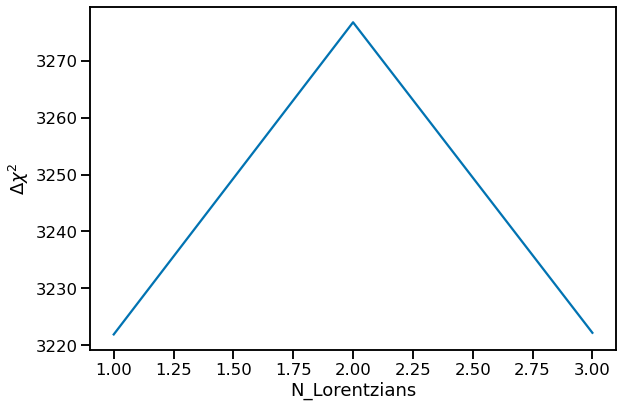

In [15]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir, f_res = f_res, text='Obs 004')

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L)) + 1, -del_chisq)
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\Delta\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()


In [16]:
best_fit_i = 1
best_popt = popt_list[best_fit_i]
best_pcov = pcov_list[best_fit_i]
best_chisq = chisq[best_fit_i]

dof = len(averaged_cross.power)-len(best_popt)

print(chisq0/(len(averaged_cross.power)-1))
print(best_chisq/dof)

print(best_popt)
print(best_pcov)

1.011885668822235
0.9619575752971571
[5.32227312e-05 2.62398943e+00 5.03989356e-05 4.54241636e-01
 9.76368534e-02 3.13199295e-02]
[[ 1.82315891e-04  1.05092535e-02  1.72561554e-04  2.51069983e-03
   1.07296230e-04 -1.40603689e-04]
 [ 1.05092535e-02  1.36000705e+00  9.94517516e-03  3.53923597e-01
   1.06050046e-02 -1.56238260e-02]
 [ 1.72561554e-04  9.94517516e-03  1.63329106e-04  2.37588722e-03
   1.01539282e-04 -1.33059087e-04]
 [ 2.51069983e-03  3.53923597e-01  2.37588722e-03  1.04802091e-01
   2.72817459e-03 -4.54066460e-03]
 [ 1.07296230e-04  1.06050046e-02  1.01539282e-04  2.72817459e-03
   1.00032010e-04 -1.36399641e-04]
 [-1.40603689e-04 -1.56238260e-02 -1.33059087e-04 -4.54066460e-03
  -1.36399641e-04  2.22225317e-04]]


## Add 2Hz feature

In [17]:
temp_p0 = np.concatenate([best_popt[:(best_fit_i+1)], [2.0], best_popt[(best_fit_i+1):(best_fit_i+1)*2], [10.], \
                          best_popt[(best_fit_i+1)*2:(best_fit_i+1)*3], [1e-2]])
# print(temp_p0)

popt, pcov = scipy.optimize.curve_fit(N_Lorentzian, averaged_cross.freq, averaged_cross.power, sigma = averaged_cross.power_err, p0 = temp_p0)

print(popt)
print(np.sqrt(np.diag(pcov)))
print(np.sum(((averaged_cross.power - N_Lorentzian(averaged_cross.freq, *popt)) / averaged_cross.power_err) ** 2) - best_chisq)
print(np.sum(((averaged_cross.power - N_Lorentzian(averaged_cross.freq, *popt)) / averaged_cross.power_err) ** 2)/(len(averaged_cross.power) - len(popt)))
print('\n')

for i in range(int(len(popt)/3)):
    nu_0 = popt[i]
    Q = popt[3 + i]
    A = popt[6 + i]

    nu_0_err = np.sqrt(np.diag(pcov))[i]
    Q_err = np.sqrt(np.diag(pcov))[3 + i]
    A_err = np.sqrt(np.diag(pcov))[6 + i]

    nu_max = nu_0*np.sqrt(1+(1/(4*np.square(Q))))
    nu_max_err = np.sqrt(np.square(nu_max*nu_0_err/nu_0) + np.square(np.square(nu_0)*Q_err/(4*nu_max*np.power(Q, 3))))

    rms = np.sqrt(A)
    rms_err = A_err/(2*np.sqrt(A))

    print(nu_max)
    print(nu_max_err)
    print(Q)
    print(Q_err)
    print(rms)
    print(rms_err)
    print('\n')

[0.13317115 5.03227411 2.29033481 0.14852152 0.9293639  2.59074951
 0.07955088 0.01852792 0.0089863 ]
[0.02436549 1.03209328 0.08577301 0.03479797 0.57565236 1.00727879
 0.00526361 0.00826144 0.00353709]
-30.149140789959347
0.9615415073536833


0.4676834868762762
0.13213974791752983
0.14852152078782793
0.03479797459845486
0.28204765493706335
0.009331073811457117


5.714338517807207
1.4159109490588222
0.9293639041086372
0.5756523588927467
0.1361173106851399
0.030346763274859336


2.332598701955284
0.09322881466199759
2.5907495050890224
1.0072787888306034
0.09479608844984662
0.018656318548678212




In [18]:
plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, (averaged_cross_log.power)*averaged_cross_log.freq, xerr=averaged_cross_log_err, \
             yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5, color='black')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)

styles = ['dashed', 'dotted', 'dashdot']
for i in range(best_fit_i+2):
    L_args = [popt[i], popt[i+best_fit_i+2], popt[i+2*(best_fit_i+2)]]
    plt.plot(averaged_cross.freq, Lorentzian(averaged_cross.freq, *L_args)*averaged_cross.freq, color='red', ls=styles[i], lw=1.0)

plt.plot(averaged_cross.freq,(N_Lorentzian(averaged_cross.freq, *popt))*averaged_cross.freq, color='red', lw=1.0)
plt.xscale('log')
plt.ylim((1e-4,1))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.text(2e-3, 0.3, 'Obs 004', fontsize=20)
plt.tight_layout()
plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_' + str(int(best_fit_i+1)) + '_comps_QPO.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, (averaged_cross_log.power), xerr=averaged_cross_log_err, \
             yerr=averaged_cross_log.power_err, fmt='none', lw=0.5, color='black')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)

for i in range(best_fit_i+2):
    L_args = [popt[i], popt[i+best_fit_i+2], popt[i+2*(best_fit_i+2)]]
    plt.plot(averaged_cross.freq, Lorentzian(averaged_cross.freq, *L_args), color='red', ls=styles[i], lw=1.0)

plt.plot(averaged_cross.freq,(N_Lorentzian(averaged_cross.freq, *popt)), color='red', lw=1.0)
plt.xscale('log')
plt.ylim((1e-4,1))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.text(2e-3, 0.3, 'Obs 004', fontsize=20)
plt.tight_layout()
plt.savefig(plot_dir + 'CPDS_Pnu_continuum_' + str(int(best_fit_i+1)) + '_comps_QPO.pdf')
plt.close()

# Scan for QPOs

In [ ]:
f_min = np.min(averaged_cross.freq)
f_max = np.min([2000., (np.max(averaged_cross.freq))])
freqs, chisq0, chisq, dof = QPO_scan(averaged_cross, f_min=f_min, f_max=f_max, f_bin = 500)

In [56]:
print(chisq0/dof)
print(chisq0)
plt.figure(figsize=(9,6))
plt.plot(freqs, (chisq - chisq0))
plt.xscale('log')
plt.ylabel(r'$\Delta\chi^{2}$')
plt.xlabel('Frequency (Hz)')
plt.tight_layout()
plt.savefig(plot_dir + 'QPO_scan.pdf')
plt.close()

1.0028494714561906
2053827.6947465069


In [39]:
peaks, _ = scipy.signal.find_peaks(-(chisq - chisq0), height = 8.0)
QPO_candidates = []
f_mask = (averaged_cross.freq > f_min) * (averaged_cross.freq < f_max) 
xdata = averaged_cross.freq[f_mask]
ydata = averaged_cross.power[f_mask]
sigma = averaged_cross.power_err[f_mask]

popt_arr, pcov_arr = fit_peaks(xdata, ydata, sigma, freqs[peaks])

sigma_arr = []

for i in range(len(popt_arr)):
    print(popt_arr[i])
#     print(np.sqrt(np.diag(pcov_arr[i])))
    sigma_arr.append(np.sqrt(np.diag(pcov_arr[i])))
sigma_arr = np.array(sigma_arr)

for i in range(len(popt_arr)):
    print(popt_arr[i][2]/sigma_arr[i][2])
    

[ 0.30843404  1.          0.26336862  0.0374417  -0.57530608]
18.858554789352702


In [41]:
plt.ion()

f_res = 0.1
plt.figure(figsize=(9,6))
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
temp_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power.real*averaged_cross_log.freq, xerr=temp_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5)
plt.plot(averaged_cross_log.freq, Lorentzian_power(averaged_cross_log.freq, *(popt_arr[0]))*averaged_cross_log.freq, color='red')
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power.real)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Leahy Power')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'averaged_cross_spectrum_' + str(int(split_time)) + 's_QPO_fit.pdf')
plt.close()



# RMS-Energy relation

In [19]:
keV_list = np.array([[3.0, 5.0], [5.0, 8.0], [8.0, 15.0], [15.0, 50.0]])
PI_list = eV_to_PI(keV_list*1000)
rms_list = []
rms_err_list = []
uplim_list = []

for x in PI_list:
    print(x)
    rms, rms_err, uplim = get_rms(events, [centroid_A, centroid_B], extraction_radius, PI_min=x[0], PI_max=x[1], nu_min=1e-4, nu_max=10., split_time=split_time, bin_time = bin_time, plot = False)
    rms_list.append(rms*100)
    rms_err_list.append(rms_err*100)
    uplim_list.append(uplim)





[35. 85.]


/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
173it [00:12, 14.05it/s]
173it [00:09, 17.81it/s]
173it [00:09, 18.81it/s]


[ 85. 160.]


173it [00:09, 18.47it/s]
173it [00:08, 21.50it/s]
173it [00:09, 17.37it/s]


[160. 335.]


173it [00:11, 15.46it/s]
173it [00:08, 19.48it/s]
173it [00:10, 16.84it/s]


[ 335. 1210.]


173it [00:10, 16.02it/s]
173it [00:08, 19.45it/s]
173it [00:09, 18.10it/s]


In [22]:
print(uplim_list)
fig, ax = plt.subplots(figsize=(9,6))
ax.errorbar((keV_list.T[0]+keV_list.T[1])/2, rms_list, xerr = (keV_list.T[0]-keV_list.T[1])/2, yerr = rms_err_list, fmt='none', lw=1.0, uplims=uplim_list)
ax.set_xscale('log')
# plt.yscale('log')
ax.set_ylabel(r'$\mathrm{rms\ (\%)}$')
ax.set_xlabel('Energy (keV)')
ax.set_xticks([3, 4, 5, 6, 7, 8,9, 20, 30, 40, 50], minor=True)
ax.set_xticks([10], minor=False)
ax.set_xticklabels(['3','','','','','','','','','','50'], minor=True)
ax.set_xticklabels(['10'], minor=False)
ax.text(3, 20.8, 'Obs 004', fontsize=20)
plt.tight_layout()
plt.savefig(plot_dir + 'rms_E.pdf')
plt.close()

[False, False, False, False]


In [32]:
print(averaged_cross.freq[0])
print(averaged_cross.freq[-1])

0.00390625
255.99609375


## Epoch 3 (OBS 006)

In [2]:
OBSID = '90601315006'

if platform=='linux' or platform=='linux2':
    print('Working on SRL server')
    root_dir = '/disk/lif2/spike/AT2019wey/'
elif platform=='darwin':
    print('Working on Macbook')
    root_dir = '/Volumes/Samsung_1TB/AstroData/AT2019wey/'

products_dir = root_dir + OBSID + '_products/'
timing_dir = root_dir + OBSID + '_timing_products/'
plot_dir = root_dir + 'figures/' + OBSID + '/'


Working on Macbook


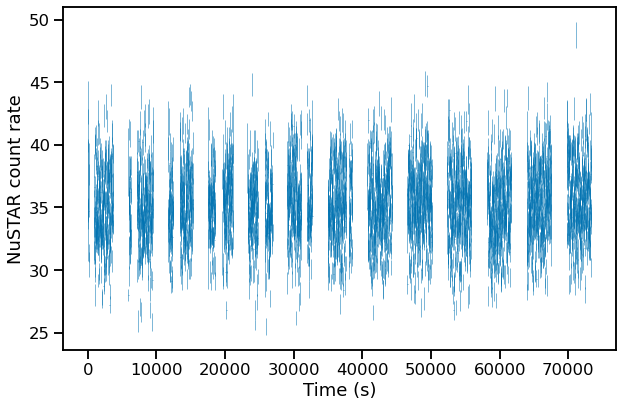

In [3]:
plt.ion()
PI_min = 35     # 3.0 keV
# PI_min = 260     # 12.0 keV
# PI_max = 960   # 40.0 keV
PI_max = 1909   # 78.0 keV
events = extract_events(timing_dir + 'nu' + OBSID + 'A01_cl_barycorr.evt', \
            timing_dir + 'nu' + OBSID + 'B01_cl_barycorr.evt')

centroid_A = [543.75912,438.48496]
centroid_B = [537.75391,438.20212]
extraction_radius = 36.613536 # 90 arsec

plt.ion()

curveA = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'A01_bk.lc'))
curveB = bkg_subtract(nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_sr.lc'), nuproducts_to_stingray_lc(products_dir + 'nu' + OBSID + 'B01_bk.lc'))
curve_total = sum_lc(curveA, curveB)
curve_10s = curve_total.rebin(dt_new=10)

t_start = np.min(curve_total.time)

plt.figure(figsize = (9,6))
plt.errorbar(curve_10s.time-t_start, curve_10s.countrate, xerr=curve_10s.dt/2., yerr=curve_10s.countrate_err, fmt='none', lw = 0.5)
plt.xlabel('Time (s)')
plt.ylabel('NuSTAR count rate')
plt.tight_layout()
plt.show()
plt.close()



In [4]:
bin_time = 1/512
split_time = 256

curve_A = events[0].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_A, radius = extraction_radius)
curve_B = events[1].to_lc(dt = bin_time, pi_low=PI_min, pi_high=PI_max, centroid = centroid_B, radius = extraction_radius)

averaged_cross = crossspec.AveragedCrossspectrum(curve_A, curve_B, segment_size=split_time, norm = 'frac')



/Users/sean/anaconda/lib/python3.6/site-packages/stingray/utils.py:118: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
144it [00:08, 17.16it/s]
144it [00:06, 21.19it/s]
144it [00:07, 19.07it/s]


In [5]:
f_res = 0.2
averaged_cross_log = averaged_cross.rebin_log(f=f_res)
averaged_cross_log_err = averaged_cross.df*np.power(1.+f_res, range(len(averaged_cross_log.freq)))/2.

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power*averaged_cross_log.freq, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_nuPnu_' + str(int(split_time)) + 's.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, averaged_cross_log.power, xerr=averaged_cross_log_err, yerr=averaged_cross_log.power_err, fmt='none', color='black', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,5*np.max(averaged_cross_log.power)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'CPDS_Pnu_' + str(int(split_time)) + 's.pdf')
plt.close()

# Model continuum

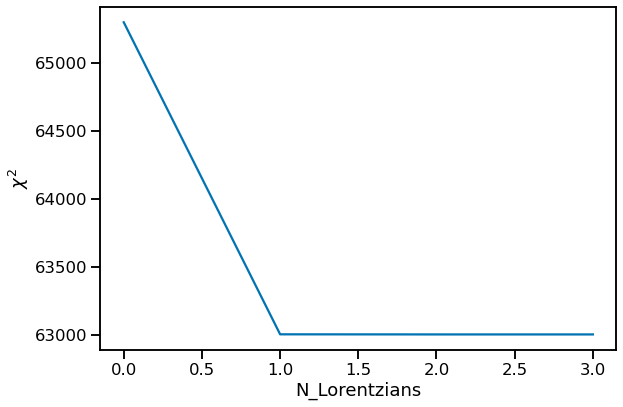

In [6]:
n_L, popt_list, pcov_list, chisq0, chisq = model_continuum_noise(averaged_cross, plot=True, plot_dir=plot_dir, f_res = f_res)

del_chisq = np.array(chisq) - chisq0

plt.figure(figsize=(9,6))
plt.plot(np.array(range(n_L+1)), np.concatenate(([chisq0], chisq)))
plt.xlabel('N_Lorentzians')
plt.ylabel(r'$\chi^{2}$')
# plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()


In [7]:
best_fit_i = 0
best_popt = popt_list[best_fit_i]
best_pcov = pcov_list[best_fit_i]
best_chisq = chisq[best_fit_i]

dof = len(averaged_cross.power)-len(best_popt)

print(chisq0/(len(averaged_cross.power)-1))
print(best_chisq/dof)

print(best_popt)
print(best_pcov)

0.9963616834423288
0.9614034503470825
[0.04533844 0.02645446 0.10531067]
[[ 5.15587815e-03  3.08455344e-03 -5.37778934e-04]
 [ 3.08455344e-03  1.84652511e-03 -3.24182568e-04]
 [-5.37778934e-04 -3.24182568e-04  6.58483398e-05]]


## Add 2Hz feature

In [10]:
temp_p0 = np.concatenate([best_popt[:(best_fit_i+1)], [2.0], best_popt[(best_fit_i+1):(best_fit_i+1)*2], [10.], \
                          best_popt[(best_fit_i+1)*2:(best_fit_i+1)*3], [1e-2]])
# print(temp_p0)

n_L = int(len(temp_p0)/3)

popt, pcov = scipy.optimize.curve_fit(N_Lorentzian, averaged_cross.freq, averaged_cross.power, sigma = averaged_cross.power_err, p0 = temp_p0, \
                                      bounds=([0.0 for i in range(3*n_L)], [np.inf for i in range(3*n_L)]))

print(popt)
print(np.sqrt(np.diag(pcov)))
print(np.sum(((averaged_cross.power - N_Lorentzian(averaged_cross.freq, *popt)) / averaged_cross.power_err) ** 2) - best_chisq)
print(np.sum(((averaged_cross.power - N_Lorentzian(averaged_cross.freq, *popt)) / averaged_cross.power_err) ** 2)/(len(averaged_cross.power) - len(popt)))
print('\n')

for i in range(int(len(popt)/3)):
    nu_0 = popt[i]
    Q = popt[2 + i]
    A = popt[4 + i]

    nu_0_err = np.sqrt(np.diag(pcov))[i]
    Q_err = np.sqrt(np.diag(pcov))[2 + i]
    A_err = np.sqrt(np.diag(pcov))[4 + i]

    nu_max = nu_0*np.sqrt(1+(1/(4*np.square(Q))))
    nu_max_err = np.sqrt(np.square(nu_max*nu_0_err/nu_0) + np.square(np.square(nu_0)*Q_err/(4*nu_max*np.power(Q, 3))))

    rms = np.sqrt(A)
    rms_err = A_err/(2*np.sqrt(A))

    print(nu_max)
    print(nu_max_err)
    print(Q)
    print(Q_err)
    print(rms)
    print(rms_err)
    print('\n')

[0.26939047 3.70069303 0.23841105 1.29987707 0.06771432 0.02100593]
[0.02739941 0.21553098 0.03795827 0.33594075 0.00466147 0.00400654]
-71.88344426475669
0.9603504931233539


0.6259097414417802
0.10317468727304002
0.23841104973552357
0.03795826662376219
0.26021975221983135
0.008956787143216509


3.965024434787971
0.26602665587488816
1.2998770652047427
0.33594074602288415
0.14493421379566382
0.01382193779968186




In [15]:
plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, (averaged_cross_log.power)*averaged_cross_log.freq, xerr=averaged_cross_log_err, \
             yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5, color='black')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)

for i in range(best_fit_i+2):
    L_args = [popt[i], popt[i+best_fit_i+2], popt[i+2*(best_fit_i+2)]]
    plt.plot(averaged_cross.freq, Lorentzian(averaged_cross.freq, *L_args)*averaged_cross.freq, color='red', ls='dotted', lw=0.5)

plt.plot(averaged_cross.freq,(N_Lorentzian(averaged_cross.freq, *popt))*averaged_cross.freq, color='red', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,3*np.max(averaged_cross_log.power.real*averaged_cross_log.freq)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_' + str(n_L) + '_comps.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, (averaged_cross_log.power), xerr=averaged_cross_log_err, \
             yerr=averaged_cross_log.power_err, fmt='none', lw=0.5, color='black')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)


for i in range(best_fit_i+2):
    L_args = [popt[i], popt[i+best_fit_i+2], popt[i+2*(best_fit_i+2)]]
    plt.plot(averaged_cross.freq, Lorentzian(averaged_cross.freq, *L_args), color='red', ls='dotted', lw=0.5)

plt.plot(averaged_cross.freq,(N_Lorentzian(averaged_cross.freq, *popt)), color='red', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,3*np.max(averaged_cross_log.power.real)))
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
plt.savefig(plot_dir + 'CPDS_Pnu_continuum_' + str(n_L) + '_comps.pdf')
plt.close()

## Another one

In [20]:
temp_p0 = np.concatenate([popt[:2], [0.9], popt[2:4], [10.], popt[4:6], [1e-2]])
# print(temp_p0)

n_L = int(len(temp_p0)/3)
new_popt, new_pcov = scipy.optimize.curve_fit(N_Lorentzian, averaged_cross.freq, averaged_cross.power, sigma = averaged_cross.power_err, p0 = temp_p0, \
                                      bounds=([0.0 for i in range(3*n_L)], [np.inf for i in range(3*n_L)]))

print(new_popt)
print(np.sqrt(np.diag(new_pcov)))
print(np.sum(((averaged_cross.power - N_Lorentzian(averaged_cross.freq, *new_popt)) / averaged_cross.power_err) ** 2) - best_chisq)
print(np.sum(((averaged_cross.power - N_Lorentzian(averaged_cross.freq, *new_popt)) / averaged_cross.power_err) ** 2)/(len(averaged_cross.power) - len(new_popt)))
print('\n')

for i in range(int(len(new_popt)/3)):
    nu_0 = new_popt[i]
    Q = new_popt[3 + i]
    A = new_popt[6 + i]

    nu_0_err = np.sqrt(np.diag(new_pcov))[i]
    Q_err = np.sqrt(np.diag(new_pcov))[3 + i]
    A_err = np.sqrt(np.diag(new_pcov))[6 + i]

    nu_max = nu_0*np.sqrt(1+(1/(4*np.square(Q))))
    nu_max_err = np.sqrt(np.square(nu_max*nu_0_err/nu_0) + np.square(np.square(nu_0)*Q_err/(4*nu_max*np.power(Q, 3))))

    rms = np.sqrt(A)
    rms_err = A_err/(2*np.sqrt(A))

    print(nu_max)
    print(nu_max_err)
    print(Q)
    print(Q_err)
    print(rms)
    print(rms_err)
    print('\n')

[2.72502171e-01 3.80971054e+00 2.16753186e+00 2.42098068e-01
 1.51202083e+00 2.36346674e+01 6.77885701e-02 1.88635063e-02
 9.93670057e-04]
[2.68295301e-02 1.99363154e-01 2.35709210e-02 3.70642162e-02
 4.04492197e-01 1.81961979e+01 4.36041100e-03 3.69577512e-03
 5.73120120e-04]
-78.36270704736671
0.9602955803970584


0.6252945993769472
0.09901508752303478
0.2420980682445422
0.03706421616531534
0.260362382362826
0.008373734632027665


4.0126063191761645
0.2351341248958461
1.5120208286326215
0.40449219721489715
0.1373444805545108
0.01345439986389484


2.168016844547297
0.023588016375789476
23.634667358546693
18.196197873053972
0.031522532529613824
0.009090642066226218




In [21]:
plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, (averaged_cross_log.power)*averaged_cross_log.freq, xerr=averaged_cross_log_err, \
             yerr=averaged_cross_log.power_err*averaged_cross_log.freq, fmt='none', lw=0.5, color='black')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power*averaged_cross_log.freq, [(averaged_cross_log.power*averaged_cross_log.freq)[-1]]]), where='post', color='black', lw=0.5)

n_L = int(len(new_popt)/3)
for i in range(n_L):
    L_args = [new_popt[i], new_popt[i+n_L], new_popt[i+2*n_L]]
    plt.plot(averaged_cross.freq, Lorentzian(averaged_cross.freq, *L_args)*averaged_cross.freq, color='red', ls='dotted', lw=0.5)

plt.plot(averaged_cross.freq,(N_Lorentzian(averaged_cross.freq, *new_popt))*averaged_cross.freq, color='red', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,1)
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{\nu P_{\nu}\ (rms/mean)^{2}}$')
plt.tight_layout()
plt.savefig(plot_dir + 'CPDS_nuPnu_continuum_' + str(n_L-1) + '_comps_QPO.pdf')
plt.close()

plt.figure(figsize=(9,6))
plt.errorbar(averaged_cross_log.freq, (averaged_cross_log.power), xerr=averaged_cross_log_err, \
             yerr=averaged_cross_log.power_err, fmt='none', lw=0.5, color='black')
plt.step(np.concatenate([averaged_cross_log.freq-averaged_cross_log_err, [averaged_cross_log.freq[-1]+averaged_cross_log_err[-1]]]), \
         np.concatenate([averaged_cross_log.power, [averaged_cross_log.power[-1]]]), where='post', color='black', lw=0.5)


for i in range(n_L):
    L_args = [new_popt[i], new_popt[i+n_L], new_popt[i+2*n_L]]
    plt.plot(averaged_cross.freq, Lorentzian(averaged_cross.freq, *L_args), color='red', ls='dotted', lw=0.5)

plt.plot(averaged_cross.freq,(N_Lorentzian(averaged_cross.freq, *new_popt)), color='red', lw=0.5)
plt.xscale('log')
plt.ylim((1e-4,1)
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$\mathrm{Power\ (rms/mean)^{2}/Hz}$')
plt.tight_layout()
plt.savefig(plot_dir + 'CPDS_Pnu_continuum_' + str(n_L-1) + '_comps_QPO.pdf')
plt.close()